In [138]:
import pandas as pd
import matplotlib.cm as cm
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn import datasets, decomposition
from sklearn.manifold import TSNE

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys, Descriptors, Descriptors3D, Draw, rdMolDescriptors, Draw, PandasTools
from rdkit.DataManip.Metric.rdMetricMatrixCalc import GetTanimotoSimMat, GetTanimotoDistMat
from rdkit.Chem.Draw import IPythonConsole

%config Completer.use_jedi = False
PandasTools.RenderImagesInAllDataFrames(images=True)

import sys
!conda install --yes --prefix {sys.prefix} seaborn
import seaborn as sns

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.11.0
  latest version: 23.3.1

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.3.1



# All requested packages already installed.



In [146]:
df = pd.read_csv(r"/Users/allenchoy/Downloads/irap_bb1_f_1.csv")
print(df)

     docking score                                       SMILES
0          -10.154      CNC(=O)C[C@H]([NH3+])c(c1)ccc(c12)cccc2
1           -9.859      CNC(=O)[C@@H](C[NH3+])Cc1cccc(c12)cccc2
2           -9.653     CNC(=O)[C@@H](C[NH3+])Cc(c1)sc(c12)cccc2
3           -9.572           CNC(=O)[C@H](C[NH3+])Cc1ccc(Cl)cc1
4           -9.569      CNC(=O)[C@H](C[NH3+])Cc(c1)sc(c12)cccc2
..             ...                                          ...
496         -8.040           CNC(=O)[C@@H](C[NH3+])C[C@H](C)COC
497         -8.032  CNC(=O)[C@]([C@H]12)(C[NH3+])C[C@@H](C1)CC2
498         -8.028                  CNC(=O)[C@@](C)(C[NH3+])COC
499         -8.017                 CNC(=O)CC[NH2+]Cc1ccc(Cl)cc1
500          0.000   CNC(=O)[C@@H](O)[C@H]([NH3+])COc1ccc(O)cc1

[501 rows x 2 columns]


In [147]:
#t-sne : compare molecules base on structure
smiles = list(df["SMILES"])
smi=[Chem.MolFromSmiles(x) for x in smiles]
fps =  [MACCSkeys.GenMACCSKeys(x) for x in smi] 
tanimoto_sim_mat_lower_triangle=GetTanimotoSimMat(fps) #compute similartity matrix between all compounds
n_mol = len(fps)
similarity_matrix = np.ones([n_mol,n_mol])
i_lower= np.tril_indices(n=n_mol,m=n_mol,k=-1)
i_upper= np.triu_indices(n=n_mol,m=n_mol,k=1)
similarity_matrix[i_lower] = tanimoto_sim_mat_lower_triangle
similarity_matrix[i_upper] = similarity_matrix.T[i_upper] 
distance_matrix = np.subtract(1,similarity_matrix) #similarity matrix of all vs all compounds in df

In [148]:
TSNE_sim = TSNE(n_components=2,random_state=90, angle = 0.3,perplexity=50).fit_transform(distance_matrix)  #tune parameters
tsne_result = pd.DataFrame(data = TSNE_sim , columns=["TC1","TC2"]) 
tsne_result.head(5) 

/usr/local/Caskroom/miniconda/base/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/Caskroom/miniconda/base/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


AttributeError: module 'pandas.io.formats.format' has no attribute '_get_adjustment'

         TC1        TC2
0   4.167415 -15.207093
1 -12.034425  18.819941
2  -6.239075  16.555170
3 -12.566995  24.205563
4  -6.239074  16.555172

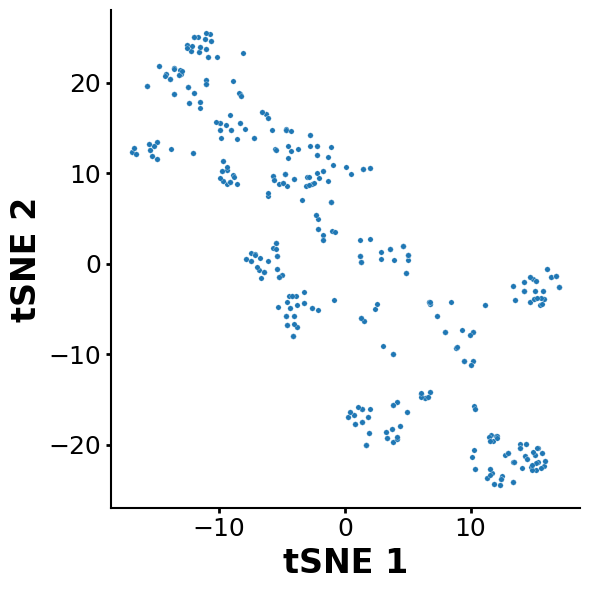

In [149]:
plt.rcParams['axes.linewidth'] = 1.5
fig, ax = plt.subplots(figsize=(6,6))

ax=sns.scatterplot(x='TC1',y='TC2',data=tsne_result,s=15,linewidth=0.2,alpha=1)
        

plt.xlabel ('tSNE 1',fontsize=24,fontweight='bold')

plt.ylabel ('tSNE 2',fontsize=24,fontweight='bold')

plt.tick_params ('both',width=2,labelsize=18)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
handles, labels = ax.get_legend_handles_labels()

plt.tight_layout()
plt.show()

In [150]:
# k-mean
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10,12] # determine best no. of clusters
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = kmeans.fit_predict(tsne_result[['TC1','TC2']])
    silhouette_avg = silhouette_score(tsne_result[['TC1','TC1']], cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg) #print the silhouette score

For n_clusters = 2 The average silhouette_score is : 0.51140517
For n_clusters = 3 The average silhouette_score is : 0.17174087
For n_clusters = 4 The average silhouette_score is : 0.18155138
For n_clusters = 5 The average silhouette_score is : 0.0776779
For n_clusters = 6 The average silhouette_score is : 0.14176807
For n_clusters = 7 The average silhouette_score is : 0.076932564
For n_clusters = 8 The average silhouette_score is : 0.062350787
For n_clusters = 9 The average silhouette_score is : 0.08682597
For n_clusters = 10 The average silhouette_score is : 0.105398245
For n_clusters = 12 The average silhouette_score is : 0.09417894


In [151]:
kmeans = KMeans(n_clusters= 6, random_state=10) 
clusters = kmeans.fit(tsne_result[['TC1','TC2']]) 

tsne_result['Cluster'] = pd.Series(clusters.labels_, index=tsne_result.index)
tsne_result.head(5) 

AttributeError: module 'pandas.io.formats.format' has no attribute '_get_adjustment'

         TC1        TC2  Cluster
0   4.167415 -15.207093        0
1 -12.034425  18.819941        3
2  -6.239075  16.555170        1
3 -12.566995  24.205563        3
4  -6.239074  16.555172        1

/usr/local/Caskroom/miniconda/base/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: The palette list has more values (20) than needed (6), which may not be intended.
  after removing the cwd from sys.path.


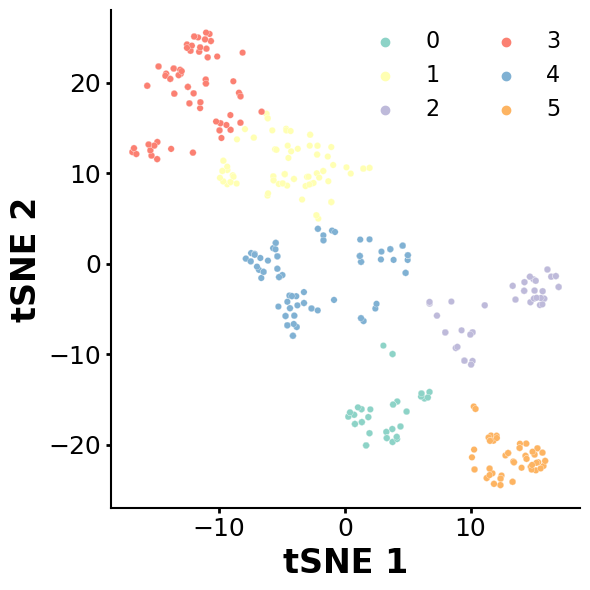

In [152]:
plt.rcParams['axes.linewidth'] = 1.5
fig, ax = plt.subplots(figsize=(6,6))

ax=sns.scatterplot(x='TC1',y='TC2',data=tsne_result, hue='Cluster',s=22,palette=sns.color_palette("Set3", 20),linewidth=0.2,alpha=1)
        

plt.xlabel ('tSNE 1',fontsize=24,fontweight='bold')

plt.ylabel ('tSNE 2',fontsize=24,fontweight='bold')

plt.tick_params ('both',width=2,labelsize=18)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

handles, labels = ax.get_legend_handles_labels()

ax.legend(handles=handles[1:], labels=labels[1:])

plt.legend(loc='best',frameon=False,prop={'size': 16},ncol=2)

plt.tight_layout()
plt.show()

In [153]:
df=df.join(tsne_result)

In [154]:
df.head

<bound method NDFrame.head of      docking score                                       SMILES        TC1  \
0          -10.154      CNC(=O)C[C@H]([NH3+])c(c1)ccc(c12)cccc2   4.167415   
1           -9.859      CNC(=O)[C@@H](C[NH3+])Cc1cccc(c12)cccc2 -12.034425   
2           -9.653     CNC(=O)[C@@H](C[NH3+])Cc(c1)sc(c12)cccc2  -6.239075   
3           -9.572           CNC(=O)[C@H](C[NH3+])Cc1ccc(Cl)cc1 -12.566995   
4           -9.569      CNC(=O)[C@H](C[NH3+])Cc(c1)sc(c12)cccc2  -6.239074   
..             ...                                          ...        ...   
496         -8.040           CNC(=O)[C@@H](C[NH3+])C[C@H](C)COC  -5.554763   
497         -8.032  CNC(=O)[C@]([C@H]12)(C[NH3+])C[C@@H](C1)CC2  -9.107464   
498         -8.028                  CNC(=O)[C@@](C)(C[NH3+])COC  -5.456078   
499         -8.017                 CNC(=O)CC[NH2+]Cc1ccc(Cl)cc1  -8.139618   
500          0.000   CNC(=O)[C@@H](O)[C@H]([NH3+])COc1ccc(O)cc1   3.879325   

           TC2  Cluster  
0   -15

In [156]:
df[["SMILES","docking score","Cluster"]].to_csv('/Users/allenchoy/Downloads/irap_bb1_f_cluster.csv',index = False)